In [1]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/6888/as22/fruits-360_dataset.zip /content
!unzip /content/fruits-360_dataset.zip

!pip install datasets
!pip install transformers
!pip install accelerate -U


Streaming output truncated to the last 5000 lines.
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/111_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/112_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/113_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/114_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/115_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/116_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/117_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/119_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/120_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/121_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/122_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/123_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Traini

# Problem 1

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, utils, initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator



base_path = '/content/fruits-360_dataset/fruits-360'
train_path = base_path + '/Training'
test_path = base_path + '/Test'


BATCH_SIZE = 1000
IMG_SIZE = (75, 75)
SEED = 42


In [3]:
train_gen, valid_gen = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.15,
    subset="both",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

test_gen = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)


# use cache to improve speed
train_gen = train_gen.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_gen = valid_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_gen = test_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


Found 67692 files belonging to 131 classes.
Using 57539 files for training.
Using 10153 files for validation.
Found 22688 files belonging to 131 classes.


In [8]:
from tensorflow.keras.applications import ResNet101, InceptionV3, EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
import time
import matplotlib.pyplot as plt


def create_and_train_model(base_model, train_gen, test_gen, freeze_layers=True):

    # Freeze layers
    if freeze_layers:
      for layer in base_model.layers:
          layer.trainable = False

    # Add Flatten layer
    # x = Flatten()(base_model.output)

    # Add GlobalAveragePooling2D layer
    x = GlobalAveragePooling2D()(base_model.output)

    # Modify pre-trained model
    output = Dense(131, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Compile
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model for 50 epochs
    history = model.fit(train_gen, validation_data=valid_gen, epochs=50)


    # Plotting Loss
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Measure inference time
    start_time = time.time()
    _, accuracy = model.evaluate(test_gen)
    end_time = time.time()
    inference_time = end_time - start_time

    # Get model size (number of parameters)
    num_params = model.count_params()

    return num_params, inference_time, accuracy


## ResNet101

171446536/171446536 [==============================] - 9s 0us/step
Epoch 1/50
58/58 [==============================] - 28s 194ms/step - loss: 1.2347 - accuracy: 0.7642 - val_loss: 0.1652 - val_accuracy: 0.9798
Epoch 2/50
58/58 [==============================] - 8s 143ms/step - loss: 0.0954 - accuracy: 0.9929 - val_loss: 0.0678 - val_accuracy: 0.9957
Epoch 3/50
58/58 [==============================] - 8s 142ms/step - loss: 0.0465 - accuracy: 0.9988 - val_loss: 0.0415 - val_accuracy: 0.9982
Epoch 4/50
58/58 [==============================] - 8s 142ms/step - loss: 0.0295 - accuracy: 0.9995 - val_loss: 0.0290 - val_accuracy: 0.9993
Epoch 5/50
58/58 [==============================] - 8s 143ms/step - loss: 0.0207 - accuracy: 0.9998 - val_loss: 0.0221 - val_accuracy: 0.9992
Epoch 6/50
58/58 [==============================] - 8s 142ms/step - loss: 0.0157 - accuracy: 0.9999 - val_loss: 0.0179 - val_accuracy: 0.9994
Epoch 7/50
58/58 [==============================] - 8s 142ms/step - loss: 0.0124

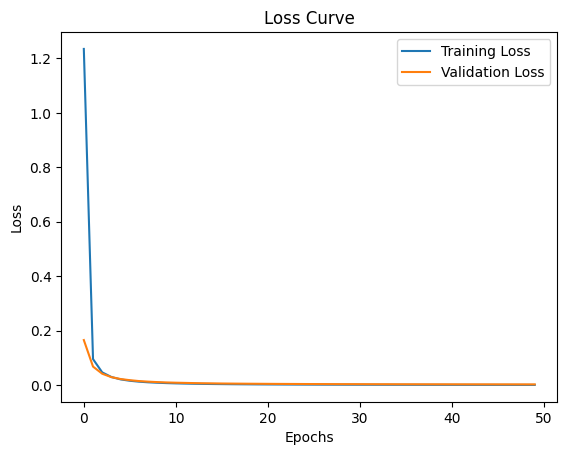

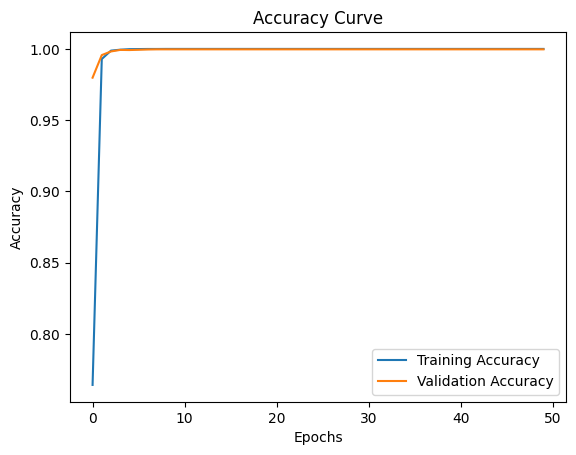

23/23 [==============================] - 4s 155ms/step - loss: 0.1712 - accuracy: 0.9628
ResNet101: Params=42926595, Time=4.070730209350586, Accuracy=0.9627556204795837


In [5]:
# Create and train ResNet101
resnet_base = ResNet101(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
resnet_params, resnet_time, resnet_acc = create_and_train_model(resnet_base, train_gen, test_gen)
print(f"ResNet101: Params={resnet_params}, Time={resnet_time}, Accuracy={resnet_acc}")



## InceptionV3

87910968/87910968 [==============================] - 5s 0us/step
Epoch 1/50
58/58 [==============================] - 11s 91ms/step - loss: 26.6165 - accuracy: 0.3867 - val_loss: 4.6378 - val_accuracy: 0.6726
Epoch 2/50
58/58 [==============================] - 3s 48ms/step - loss: 2.5244 - accuracy: 0.7726 - val_loss: 1.5055 - val_accuracy: 0.8317
Epoch 3/50
58/58 [==============================] - 3s 48ms/step - loss: 0.9762 - accuracy: 0.8784 - val_loss: 0.7874 - val_accuracy: 0.8930
Epoch 4/50
58/58 [==============================] - 3s 48ms/step - loss: 0.5081 - accuracy: 0.9252 - val_loss: 0.5160 - val_accuracy: 0.9259
Epoch 5/50
58/58 [==============================] - 3s 48ms/step - loss: 0.3164 - accuracy: 0.9443 - val_loss: 0.4190 - val_accuracy: 0.9343
Epoch 6/50
58/58 [==============================] - 3s 49ms/step - loss: 0.2281 - accuracy: 0.9570 - val_loss: 0.2801 - val_accuracy: 0.9531
Epoch 7/50
58/58 [==============================] - 3s 48ms/step - loss: 0.1501 - accur

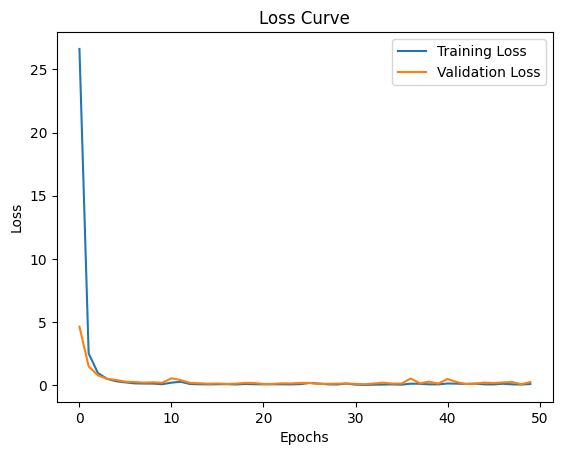

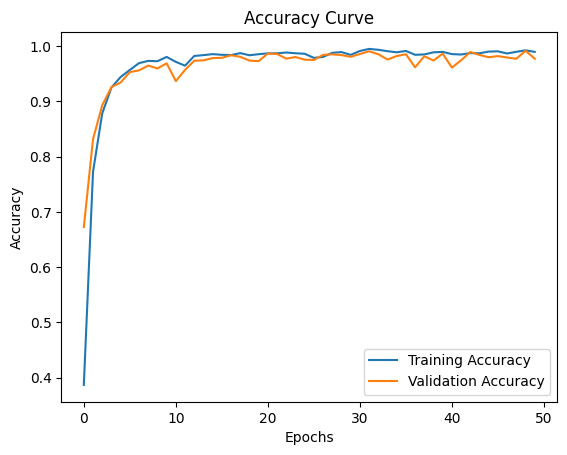

23/23 [==============================] - 2s 76ms/step - loss: 7.9492 - accuracy: 0.7607
InceptionV3: Params=22071203, Time=1.73166823387146, Accuracy=0.7607105374336243


In [6]:
# Create and train InceptionV3
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
inception_params, inception_time, inception_acc = create_and_train_model(inception_base, train_gen, test_gen)
print(f"InceptionV3: Params={inception_params}, Time={inception_time}, Accuracy={inception_acc}")


## EfficientNetB1

27018416/27018416 [==============================] - 2s 0us/step
Epoch 1/50
58/58 [==============================] - 18s 132ms/step - loss: 2.5999 - accuracy: 0.5764 - val_loss: 1.1437 - val_accuracy: 0.8882
Epoch 2/50
58/58 [==============================] - 6s 96ms/step - loss: 0.8876 - accuracy: 0.8893 - val_loss: 0.5533 - val_accuracy: 0.9470
Epoch 3/50
58/58 [==============================] - 6s 96ms/step - loss: 0.5265 - accuracy: 0.9387 - val_loss: 0.3533 - val_accuracy: 0.9706
Epoch 4/50
58/58 [==============================] - 6s 95ms/step - loss: 0.3695 - accuracy: 0.9591 - val_loss: 0.2520 - val_accuracy: 0.9829
Epoch 5/50
58/58 [==============================] - 6s 96ms/step - loss: 0.2862 - accuracy: 0.9694 - val_loss: 0.1917 - val_accuracy: 0.9879
Epoch 6/50
58/58 [==============================] - 6s 95ms/step - loss: 0.2281 - accuracy: 0.9779 - val_loss: 0.1524 - val_accuracy: 0.9914
Epoch 7/50
58/58 [==============================] - 6s 95ms/step - loss: 0.1907 - accur

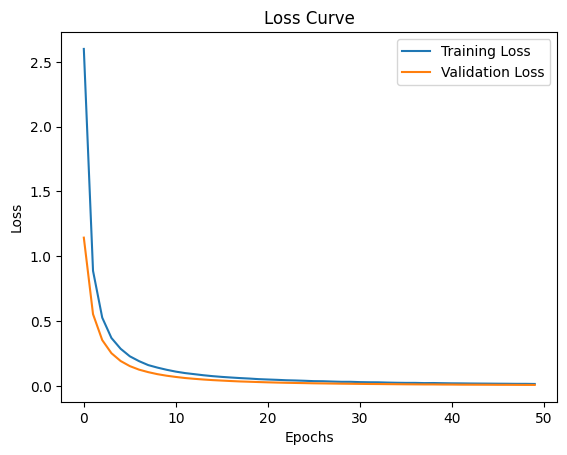

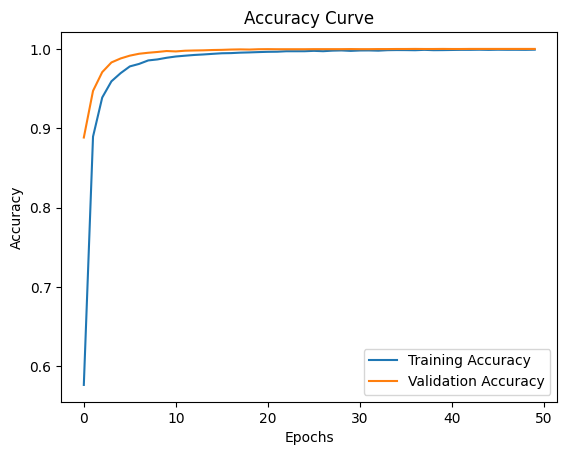

23/23 [==============================] - 2s 81ms/step - loss: 0.1541 - accuracy: 0.9604
EfficientNetB1: Params=6743050, Time=1.8692944049835205, Accuracy=0.9603755474090576


In [7]:
# Create and train EfficientNetB1
effnet_base = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
effnet_params, effnet_time, effnet_acc = create_and_train_model(effnet_base, train_gen, test_gen)
print(f"EfficientNetB1: Params={effnet_params}, Time={effnet_time}, Accuracy={effnet_acc}")

## Discussion

| Model | Dropout rate | Test accuracy |
| --- | --- | --- |
| 1 | 0.1 | 96.7% |
| 1 | 0.3 | 81.2% |
| 1 | 0.5 | 75.2% |
| 2 | 0.3 | 82.1% |

Epoch 1/50
58/58 [==============================] - 91s 429ms/step - loss: 0.2538 - accuracy: 0.9475 - val_loss: 172660.3281 - val_accuracy: 0.0066
Epoch 2/50
58/58 [==============================] - 20s 347ms/step - loss: 0.0049 - accuracy: 0.9986 - val_loss: 88.9694 - val_accuracy: 0.2452
Epoch 3/50
58/58 [==============================] - 20s 348ms/step - loss: 0.0262 - accuracy: 0.9943 - val_loss: 2925.9141 - val_accuracy: 0.0098
Epoch 4/50
58/58 [==============================] - 20s 348ms/step - loss: 0.0290 - accuracy: 0.9936 - val_loss: 647.0030 - val_accuracy: 0.0051
Epoch 5/50
58/58 [==============================] - 20s 347ms/step - loss: 0.0178 - accuracy: 0.9959 - val_loss: 370.0451 - val_accuracy: 0.0123
Epoch 6/50
58/58 [==============================] - 20s 347ms/step - loss: 0.0115 - accuracy: 0.9973 - val_loss: 35.8231 - val_accuracy: 0.0224
Epoch 7/50
58/58 [==============================] - 20s 347ms/step - loss: 0.0037 - accuracy: 0.9993 - val_loss: 1.3098 - val_ac

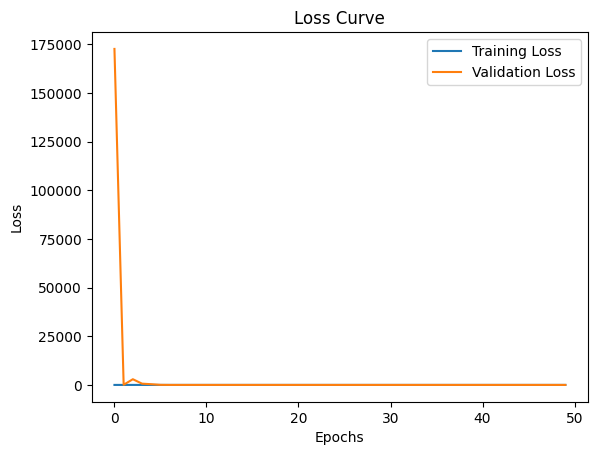

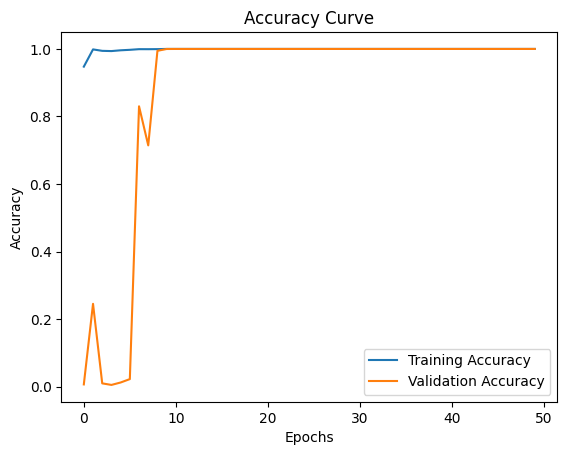

23/23 [==============================] - 3s 120ms/step - loss: 0.0478 - accuracy: 0.9914
ResNet101: Params=42926595, Time=2.7723920345306396, Accuracy=0.9913610816001892


In [9]:
# Create and train ResNet101
resnet_base = ResNet101(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
resnet_params, resnet_time, resnet_acc = create_and_train_model(resnet_base, train_gen, test_gen, freeze_layers=False)
print(f"ResNet101: Params={resnet_params}, Time={resnet_time}, Accuracy={resnet_acc}")

Epoch 1/50
58/58 [==============================] - 46s 205ms/step - loss: 1.4180 - accuracy: 0.7313 - val_loss: 118.4250 - val_accuracy: 0.0063
Epoch 2/50
58/58 [==============================] - 7s 123ms/step - loss: 0.0372 - accuracy: 0.9930 - val_loss: 317.2335 - val_accuracy: 0.0258
Epoch 3/50
58/58 [==============================] - 7s 122ms/step - loss: 0.0186 - accuracy: 0.9973 - val_loss: 3.3057 - val_accuracy: 0.5099
Epoch 4/50
58/58 [==============================] - 7s 122ms/step - loss: 0.0124 - accuracy: 0.9970 - val_loss: 0.9198 - val_accuracy: 0.8075
Epoch 5/50
58/58 [==============================] - 7s 122ms/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 0.3881 - val_accuracy: 0.8996
Epoch 6/50
58/58 [==============================] - 7s 122ms/step - loss: 0.0153 - accuracy: 0.9968 - val_loss: 4.3294 - val_accuracy: 0.6304
Epoch 7/50
58/58 [==============================] - 7s 122ms/step - loss: 0.0167 - accuracy: 0.9967 - val_loss: 7.9003 - val_accuracy: 0.1969
E

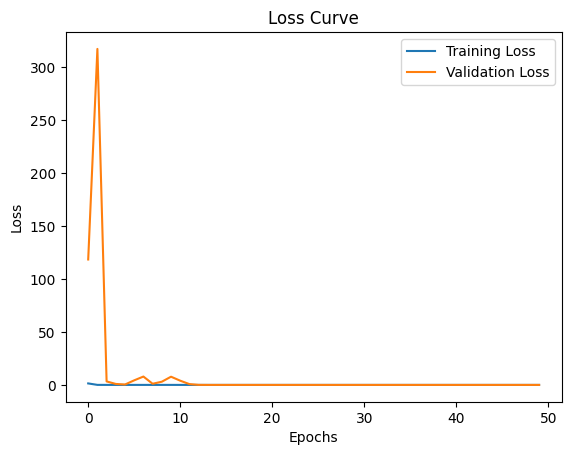

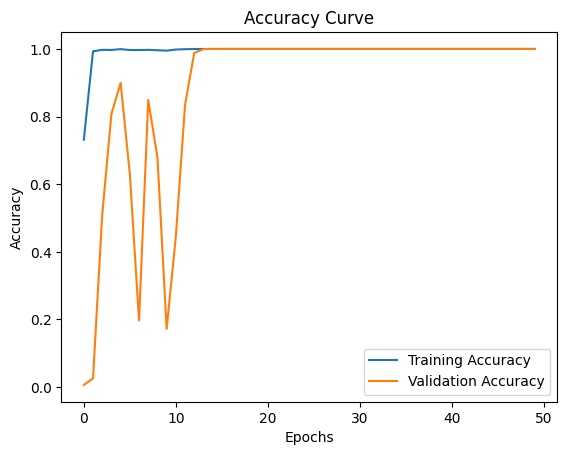

23/23 [==============================] - 1s 41ms/step - loss: 0.0902 - accuracy: 0.9843
InceptionV3: Params=22071203, Time=0.9518771171569824, Accuracy=0.9843088984489441


In [10]:
# Create and train InceptionV3
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
inception_params, inception_time, inception_acc = create_and_train_model(inception_base, train_gen, test_gen, freeze_layers=False)
print(f"InceptionV3: Params={inception_params}, Time={inception_time}, Accuracy={inception_acc}")


Epoch 1/50
58/58 [==============================] - 70s 395ms/step - loss: 0.4627 - accuracy: 0.9255 - val_loss: 1.6111 - val_accuracy: 0.5785
Epoch 2/50
58/58 [==============================] - 21s 358ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 0.1779 - val_accuracy: 0.9473
Epoch 3/50
58/58 [==============================] - 21s 359ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 0.0191 - val_accuracy: 0.9949
Epoch 4/50
58/58 [==============================] - 21s 358ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.0016 - val_accuracy: 0.9999
Epoch 5/50
58/58 [==============================] - 21s 359ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.0015 - val_accuracy: 0.9999
Epoch 6/50
58/58 [==============================] - 21s 358ms/step - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.0346 - val_accuracy: 0.9899
Epoch 7/50
58/58 [==============================] - 21s 359ms/step - loss: 0.0075 - accuracy: 0.9985 - val_loss: 0.0059 - val_accuracy: 0.9987

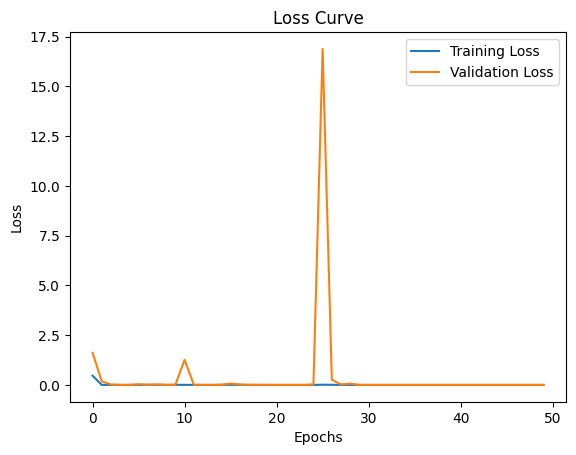

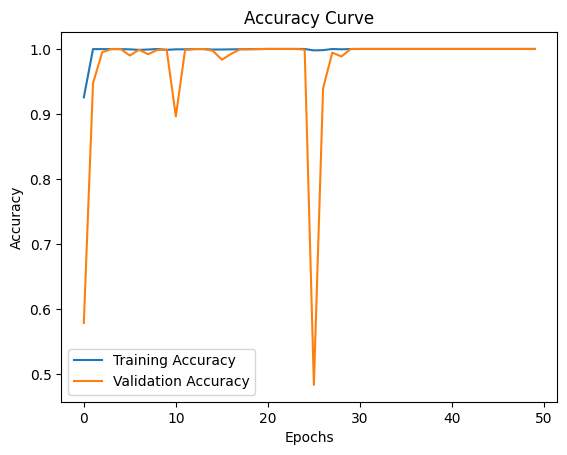

23/23 [==============================] - 2s 80ms/step - loss: 0.0142 - accuracy: 0.9960
EfficientNetB1: Params=6743050, Time=1.8652324676513672, Accuracy=0.9960331320762634


In [11]:
# Create and train EfficientNetB1
effnet_base = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
effnet_params, effnet_time, effnet_acc = create_and_train_model(effnet_base, train_gen, test_gen, freeze_layers=False)
print(f"EfficientNetB1: Params={effnet_params}, Time={effnet_time}, Accuracy={effnet_acc}")

# Problem 2

In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("imdb")
raw_train_dataset = raw_datasets['train'].train_test_split(test_size=1000)
train_dataset = raw_train_dataset['train']
val_dataset = raw_train_dataset['test']
test_dataset = raw_datasets['test']



In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

def tokenize_batch(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

train_data = train_dataset.map(tokenize_batch, batched=True)
val_data = val_dataset.map(tokenize_batch, batched=True)
test_data = test_dataset.map(tokenize_batch, batched=True)

train_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])



Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

In [ ]:
from transformers import AlbertForSequenceClassification

model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=2)


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.247200,0.182516,0.925000
2,0.173000,0.213101,0.937000
3,0.122800,0.284125,0.938000
4,0.076700,0.352288,0.930000
5,0.040400,0.369072,0.935000
6,0.022800,0.442082,0.943000
7,0.012400,0.514923,0.935000
8,0.006100,0.560036,0.936000
9,0.001900,0.621329,0.933000
10,0.000800,0.592462,0.933000


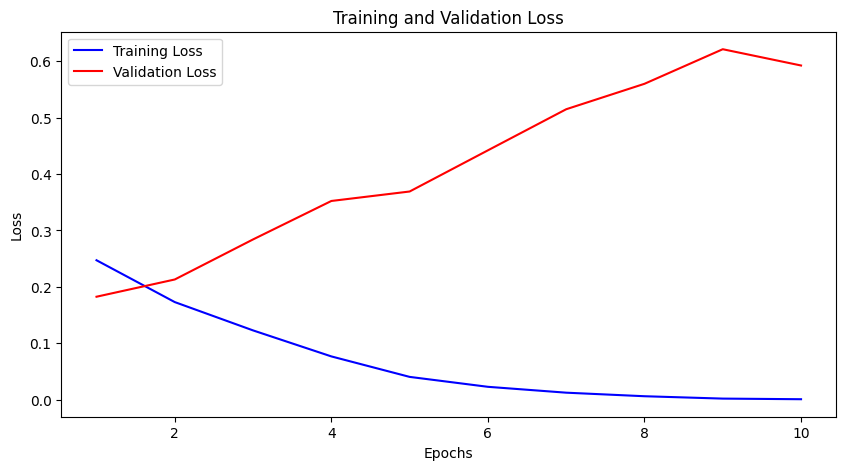

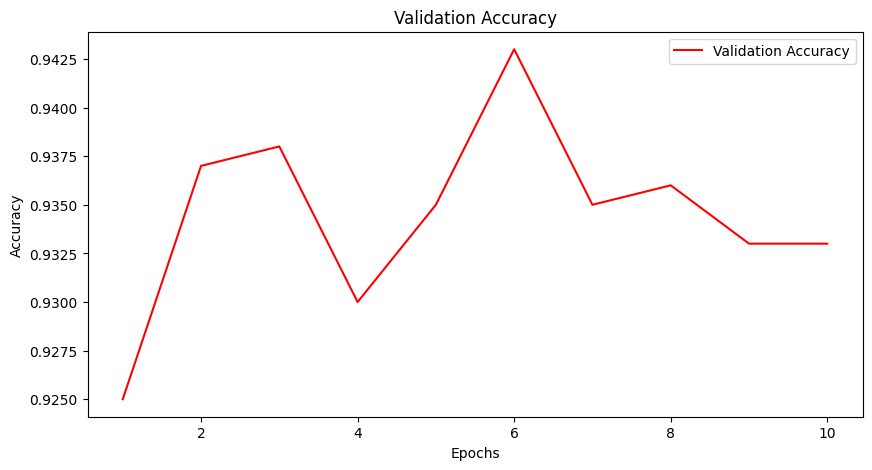

Test Accuracy: 0.93772


In [ ]:
from transformers import Trainer, TrainingArguments
from transformers import TrainerCallback
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'eval_accuracy': accuracy_score(labels, predictions)}


class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.training_losses = []
        self.validation_losses = []
        self.validation_accuracies = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.training_losses.append(logs['loss'])
        if 'eval_loss' in logs:
            self.validation_losses.append(logs['eval_loss'])
        if 'eval_accuracy' in logs:
            self.validation_accuracies.append(logs['eval_accuracy'])


metrics_callback = MetricsCallback()

training_args = TrainingArguments(
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    learning_rate=1e-5,
    weight_decay=0.01,
    num_train_epochs=10,
    output_dir='./results'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    callbacks=[metrics_callback],
    compute_metrics=compute_metrics
)

trainer.train()

training_loss = metrics_callback.training_losses
validation_loss = metrics_callback.validation_losses
validation_accuracy = metrics_callback.validation_accuracies

# Assuming that logs are saved every epoch, use this for x-axis
epochs = list(range(1, len(training_loss) + 1))

import matplotlib.pyplot as plt

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, label='Training Loss', color='blue')
plt.plot(epochs, validation_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, validation_accuracy, label='Validation Accuracy', color='red')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Test the model
evaluation_results = trainer.evaluate(eval_dataset=test_data)
print(f"Test Accuracy: {evaluation_results['eval_accuracy']}")




In [ ]:
import torch

text = "This movie was really amazing!"
tokens = tokenizer(text, padding=True, truncation=True, return_tensors="pt")

# Move tokens to the same device as the model
tokens = {key: val.to('cuda') for key, val in tokens.items()}

with torch.no_grad():  # Deactivate gradients for the following code
    outputs = model(**tokens)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    label = torch.argmax(probabilities).item()
    class_probability = probabilities[0][label].item()

# Output the results
print(f"Probabilities: {probabilities.cpu().numpy()}")  # Move tensor to CPU to convert to numpy
if label == 1:
    print(f"Prediction: Positive, Probability: {class_probability}")
else:
    print(f"Prediction: Negative, Probability: {class_probability}")


Probabilities: [[4.4176218e-04 9.9955827e-01]]
Prediction: Positive, Probability: 0.9995582699775696
